In [1]:
import sys
sys.path.append('/home/npopkov/dll24')

import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True

import numpy as np
import lightning as lt
torch.set_float32_matmul_precision('medium')
import soundfile as sf

from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

from torch.utils.data import DataLoader,Dataset

import h5py
from tqdm.auto import tqdm

class SnippetDatasetHDF(Dataset):
    def __init__(self, hdf, scaling='minmax'):
        self.num_rows = 0
        self.size = int(3.4*24000)
        self.scaling = scaling
        self.data = self.createData(hdf)
        
        if scaling == 'standard':
            self.mean = self.data.mean()
            self.std =  self.data.std()
            self.data = (self.data - self.mean) / self.std
        
        if scaling == 'minmax':
            self.min = self.data.min()
            self.max = self.data.max()
            self.data = (self.data - self.min) / (self.max - self.min)
    
    def __len__(self):
        return self.num_rows
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def createData(self, hdf):
        data = []
        keys = list(hdf.keys())
        self.num_rows = len(keys)
        for key in tqdm(keys):
            sample = hdf[key]['audio'][:]
            if len(sample) > self.size:
                self.num_rows -= 1
                continue

            if len(sample) < self.size:
                sample = np.pad(sample, (0, self.size - len(sample)), 'constant')

            data.append(sample)
         
        return torch.tensor(np.array(data)).float()

    def retransform(self, data):
        if self.scaling == 'standard':
            return data * self.std + self.mean
        if self.scaling == 'minmax':
            return data * (self.max - self.min) + self.min

hdf = h5py.File('../../../test_24k.hdf5', 'r')
dataset = SnippetDatasetHDF(hdf)
hdf.close()



/home/npopkov/dll24/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 6675/6675 [00:01<00:00, 5843.72it/s]


In [2]:
import dac
from audiotools import AudioSignal

# Download a model
model_path = dac.utils.download(model_type="24kHz")
model = dac.DAC.load(model_path)

model.to('cuda')



/home/npopkov/dll24/.conda/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


DAC(
  (encoder): Encoder(
    (block): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): EncoderBlock(
        (block): Sequential(
          (0): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (1): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (2): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,))
              (2): Snake1d()
              

In [3]:
import librosa
from IPython.display import Audio
import soundfile as sf

In [4]:
Audio(dataset[0],rate=24000)

In [5]:
# Load audio signal file
def try_and_plot(i):
    signal = AudioSignal(dataset[i],sample_rate=24000)

    # Encode audio signal as one long file
    # (may run out of GPU memory on long files)
    signal.to('cuda')

    x = model.preprocess(signal.audio_data, signal.sample_rate).to('cuda')
    z, codes, latents, _, _ = model.encode(x)
    # Decode audio signal
    y = model.decode(z)
    plt.imshow(z.squeeze().detach().cpu().numpy(), aspect='auto', origin='lower', cmap='inferno')



In [6]:
signal = AudioSignal(dataset[3],sample_rate=24000)

# Encode audio signal as one long file
# (may run out of GPU memory on long files)
signal.to('cuda')

x = model.preprocess(signal.audio_data, signal.sample_rate).to('cuda')
z, codes, latents, _, _ = model.encode(x)

torch.Size([1, 256, 256])


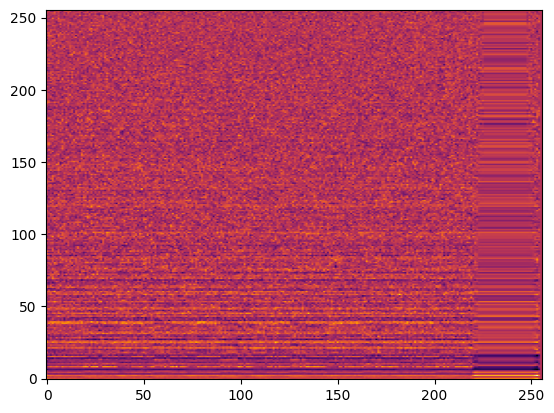

In [7]:

latents = torch.nn.functional.pad(latents, (0, 1))
print(latents.shape)

plt.imshow(latents.squeeze().detach().cpu().numpy(), aspect='auto', origin='lower', cmap='inferno')

In [8]:
test,_,_ = model.quantizer.from_latents(latents)

In [9]:
y = model.decode(test)
print(y.shape)
Audio(y.squeeze().cpu().detach().numpy(),rate=24000)

torch.Size([1, 1, 81912])


In [10]:
import h5py

# Create a new HDF file
output_file = 'encoded_samples.hdf5'
hdf_output = h5py.File(output_file, 'w')

# Encode and store each sample in the HDF file
for i in tqdm(range(len(dataset))):
    sample = dataset[i]
    signal = AudioSignal(sample, sample_rate=24000)
    signal.to('cuda')
    x = model.preprocess(signal.audio_data, signal.sample_rate).to('cuda')
    z, _, latents, _, _ = model.encode(x)
    latents = torch.nn.functional.pad(latents, (0, 1))
    hdf_output.create_dataset(f'sample_{i}', data=latents.squeeze().detach().cpu().numpy())

# Close the HDF file
hdf_output.close()

# Print the path of the output file
print(f"Encoded samples saved to: {output_file}")

100%|██████████| 5756/5756 [01:33<00:00, 61.47it/s]


Encoded samples saved to: encoded_samples.hdf5


In [17]:
hdf = h5py.File(output_file, 'r')

In [20]:
hdf.close()

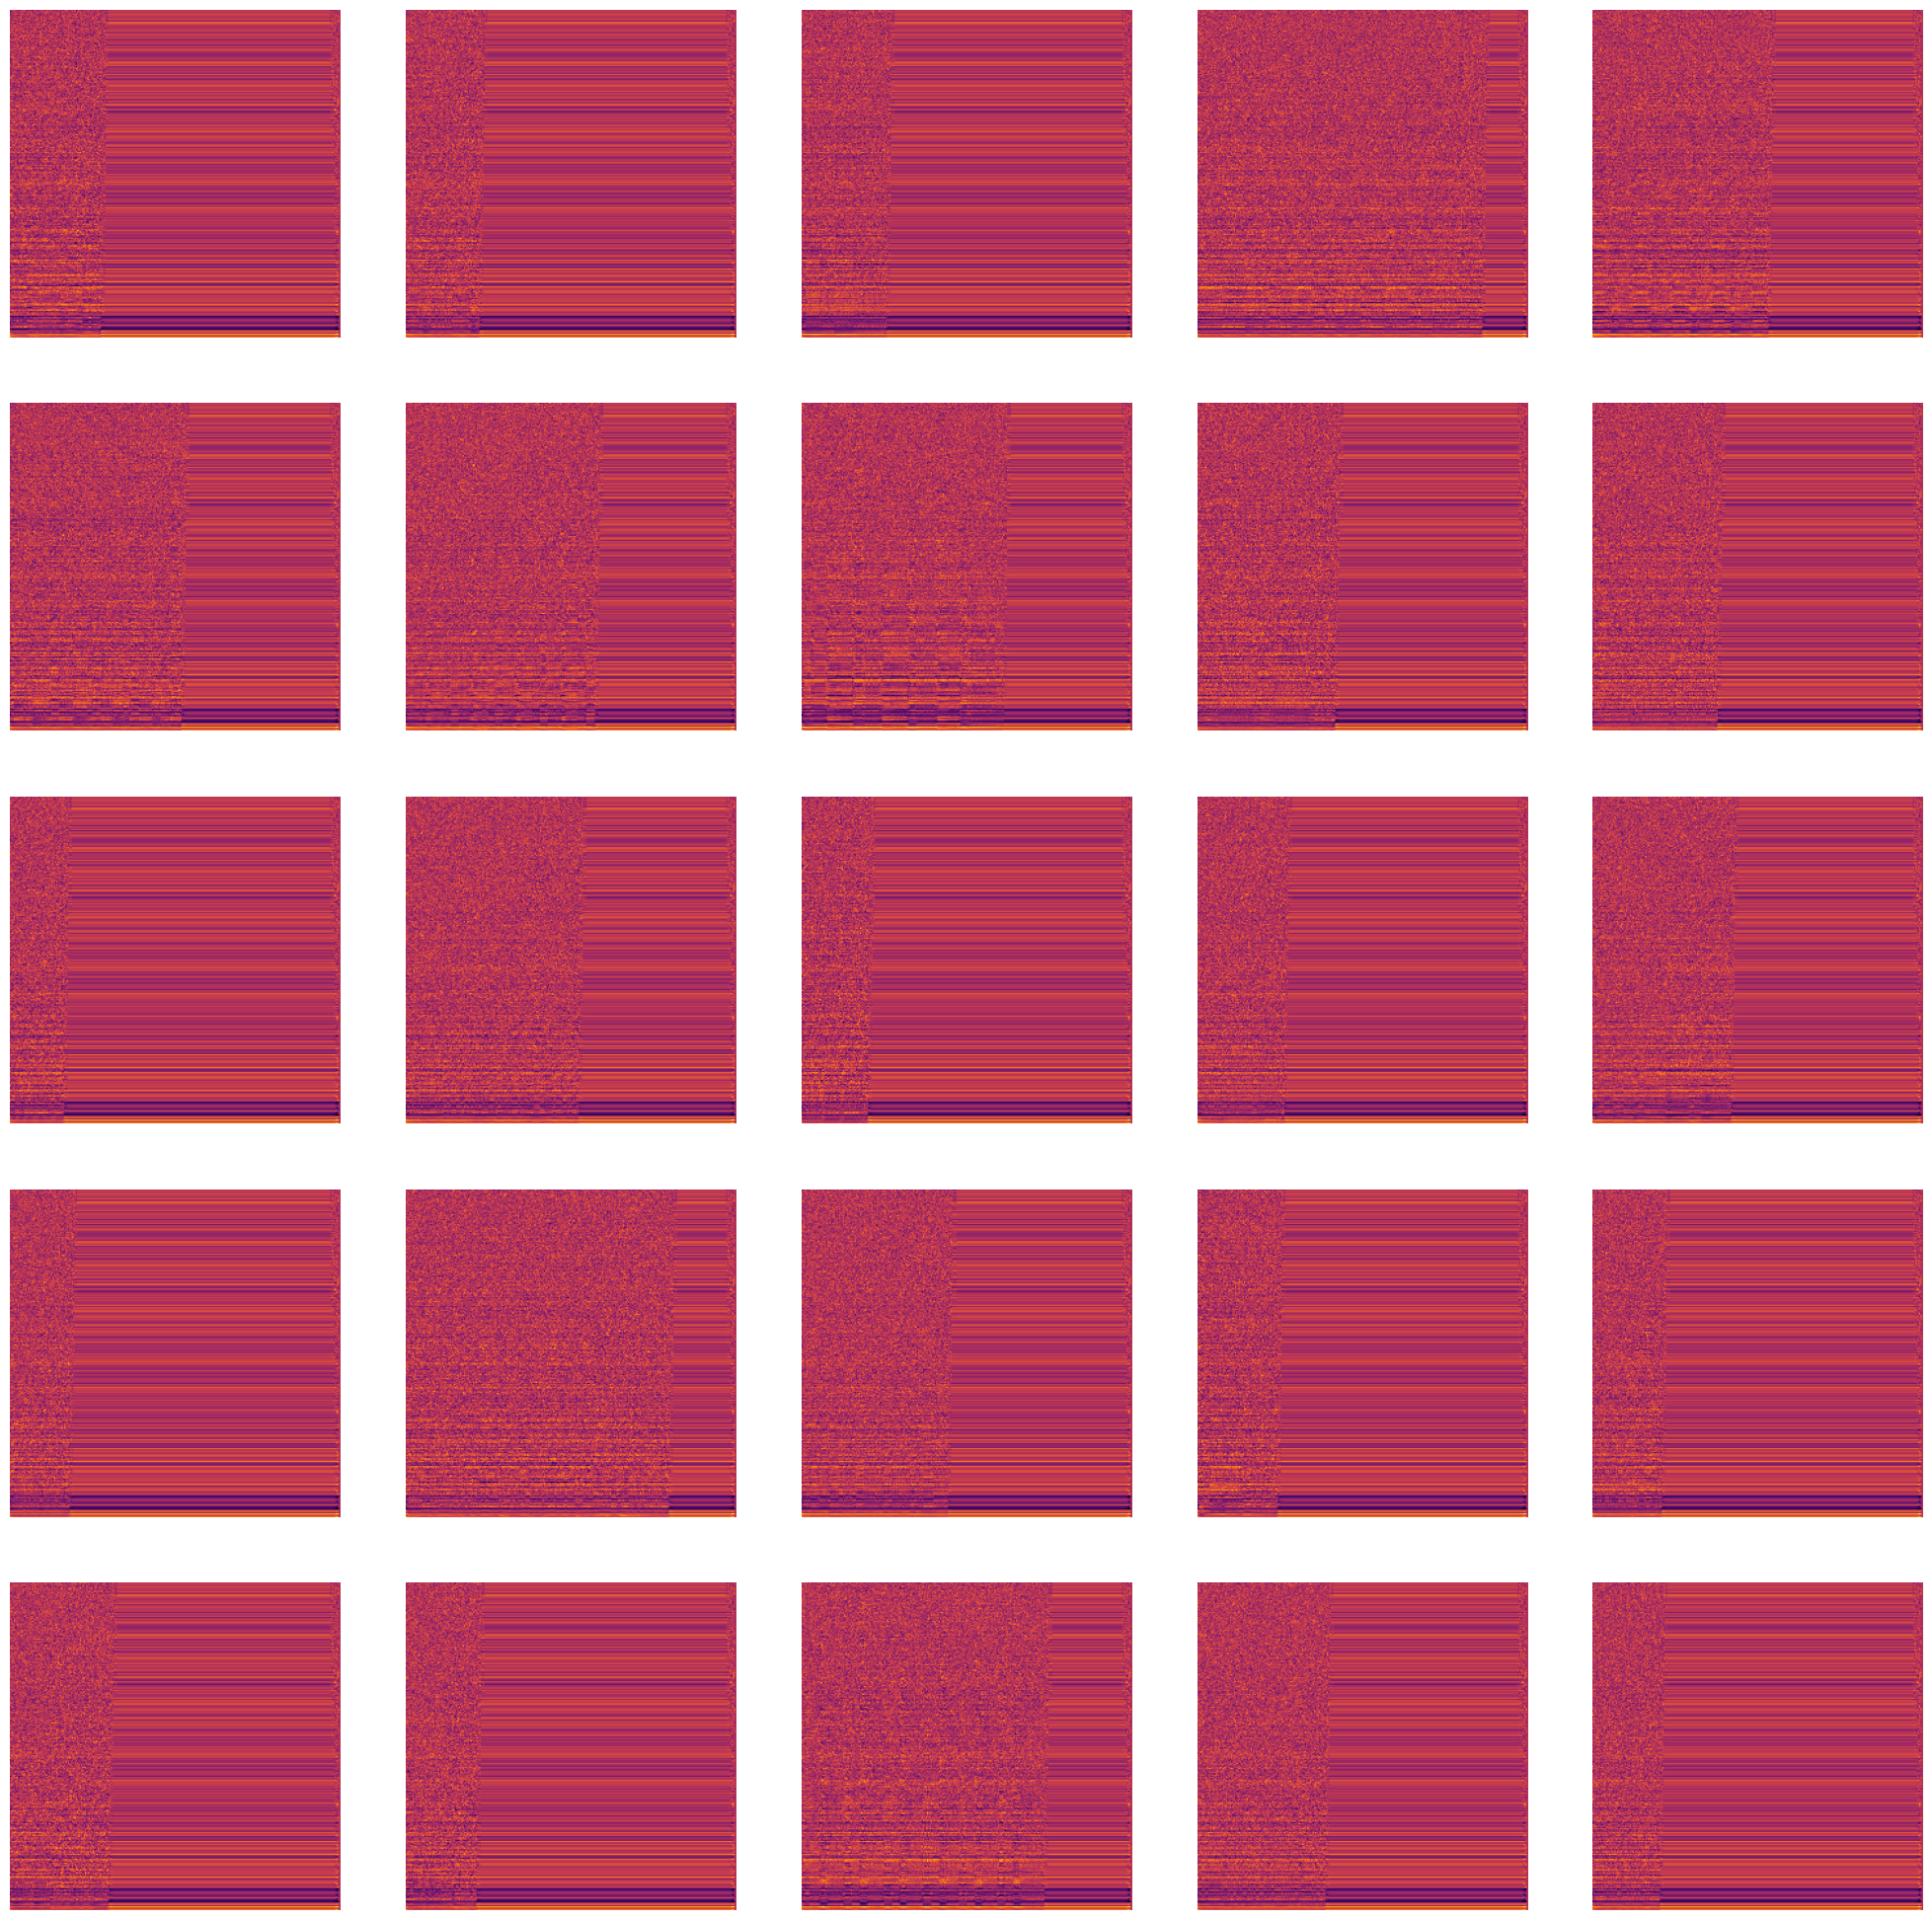

In [18]:
fig, ax = plt.subplots(5, 5, figsize=(25, 25))
for i in range(25):
    ax[i//5, i%5].imshow(np.array(hdf[f'sample_{i}']), aspect='auto', origin='lower', cmap='inferno')
    ax[i//5, i%5].axis('off')